In [247]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import dill
import loss_functions as lf
from Optimal_Stopping_Object import ModelConstructor, ModelFitting
import constants
import data_visualization as dv
from initializer import InitialThangs
from copy import deepcopy
import plot_functions as pf
import constants
import read_data_functions as rdf

wheel = dv.ColorWheel()
it = InitialThangs(experiment="Exp1")
%load_ext autoreload
%autoreload 2
plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')
# #* True Parameters load
# with open(constants.MODEL_INPUT_PATH / 'model_input_dict.pkl','rb') as f:
#     model_input_dict = dill.load(f)
# true_parameters = [np.nanmedian(v) for k,v in model_input_dict.items() if "agent" not in k] 
# #* Bootstrap Load
# with open(constants.MODEL_INPUT_PATH / 'bootstrap_parameter_distribution.pkl','rb') as f:
#     parameter_distribution = dill.load(f)    
# with open(constants.MODEL_INPUT_PATH / 'bootstrap_results.pkl','rb') as f:
#     results = dill.load(f)    
# with open(constants.MODEL_INPUT_PATH / 'participant_ids.pkl','rb') as f:
#     participant_ids = dill.load(f)        
#* Comparison Targets load
with open(constants.MODEL_INPUT_PATH / 'participant_median_movement_onset_time.pkl','rb') as f:
    participant_median_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_sd_movement_onset_time.pkl','rb') as f:
    participant_sd_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_wins.pkl','rb') as f:
    participant_wins = dill.load(f)  
participant_perc_wins = (participant_wins/it.num_trials)*100
with open(constants.MODEL_INPUT_PATH / 'participant_incorrects.pkl','rb') as f:
    participant_incorrects = dill.load(f)  
participant_perc_incorrects = (participant_incorrects/it.num_trials)*100

with open(constants.MODEL_INPUT_PATH / 'participant_indecisions.pkl','rb') as f:
    participant_indecisions = dill.load(f)  
participant_perc_indecisions = (participant_indecisions/it.num_trials)*100

np.random.seed(0)


# group = rdf.generate_subject_object_v3('Exp1', "All Trials")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import matplotlib.transforms as mtransforms
class NewFigure:
    def __init__(self, mosaic, figsize = (6.5,4), dpi=150, layout="constrained", sharex=False,sharey=False,
                 ):
        self.fig, self.axes = plt.subplot_mosaic(mosaic, 
                                                 dpi=dpi,
                                                layout=layout,
                                                figsize=figsize,
                                                sharex=sharex,
                                                sharey=sharey,
                                                )
        
        self.figw,self.figh = self.fig.get_size_inches()
        # Create axmain box for visualization of the bounds and coordinates
        self.axmain  = self.fig.add_axes((0,0,1,1))
        self.axmain.set_xlim(0,self.figw)
        self.axmain.set_ylim(0,self.figh)
        self.axmain.spines.top.set_visible(True)
        self.axmain.spines.right.set_visible(True)
        self.axmain.spines.bottom.set_visible(True)
        self.axmain.spines.left.set_visible(True)
        self.axmain.set_xlim(0,figsize[0])
        self.axmain.set_ylim(0,figsize[1])
        
        self.letters = []
                
    def pad_fig(self, w_pad, h_pad, w_space, h_space):
        self.fig.get_layout_engine().set(w_pad=w_pad/self.figw, 
                                         h_pad=h_pad/self.figh, 
                                         wspace=w_space/self.figw,
                                         hspace=h_space/self.figh)
    def ax_dim(self,ax):
        bbox = ax.get_window_extent().transformed(self.fig.dpi_scale_trans.inverted())
        return bbox.width, bbox.height
    
    def ax_loc(self,ax):
        bbox = ax.get_window_extent().transformed(self.fig.dpi_scale_trans.inverted())
        return bbox.x0,bbox.y0
        
    def set_position(self, ax, loc):
        x,y = loc
        w,h = self.ax_dim(ax)
        ax.set_position((x/self.figw, y/self.figh, w/self.figw, h/self.figh))

    def adjust_position(self, ax, adjustment):
        dx,dy = adjustment
        w,h = self.ax_dim(ax)
        x,y = self.ax_loc(ax)
        ax.set_position(((x+dx)/self.figw, (y+dy)/self.figh, w/self.figw, h/self.figh))
        
    def set_size(self, ax, size):
        w,h = size
        x,y = self.ax_loc(ax)
        ax.set_position((x/self.figw, y/self.figh, w/self.figw, h/self.figh))
        
    def adjust_size(self, ax, adjustment):
        dw,dh = adjustment
        w,h = self.ax_dim(ax)
        x,y = self.ax_loc(ax)
        ax.set_position((x/self.figw, y/self.figh, (w+dw)/self.figw, (h+dh)/self.figh))

    def add_all_letters_old(self, xy = (0,1), ax=None, fontsize=12,
                        va="top",ha='center',fontfamily="sans-serif",fontweight="bold"):
        for i,(label, ax) in enumerate(self.axes.items()):
            # label physical distance to the left and up:
            letter = ascii_uppercase[i]
            # trans = mtransforms.ScaledTranslation(-20/72, 7/72, self.fig.dpi_scale_trans)
            ax.text(xy[0], xy[1], letter, transform=ax.transAxes,
                    fontsize=fontsize, va=va,ha=ha, fontfamily=fontfamily, 
                    fontweight=fontweight)
    def add_all_letters(self, xy = (0,1), ax=None, fontsize=12,
                        va="top",ha='left',fontfamily="sans-serif",fontweight="bold"):
        for i,(label, ax) in enumerate(self.axes.items()):
            ax_bbox = ax.get_tightbbox().transformed(self.axmain.transData.inverted())
            # label physical distance to the left and up:
            letter = ascii_uppercase[i]
            # trans = mtransforms.ScaledTranslation(-20/72, 7/72, self.fig.dpi_scale_trans)
            ax.text(ax_bbox.x0, ax_bbox.y1, letter, transform=self.axmain.transData,
                    fontsize=fontsize, va=va,ha=ha, fontfamily=fontfamily, 
                    fontweight=fontweight)
    def add_letter(self, ax, x, y, letter = None, fontsize = 12, 
                   ha = "left", va = "top", color = "black", zorder = 20):
        if letter == None:
            letter_to_add = ascii_uppercase[len(self.letters)]
        else:
            letter_to_add = letter
        
        self.letters.append(letter_to_add)
        self.axmain.text(x, y, letter_to_add, ha = ha, va = va, fontweight = "bold", color = color, fontsize = fontsize, zorder = zorder)
        
    def savefig(self,path,dpi=300):
        self.fig.savefig(path,dpi=dpi)


In [380]:
SAVE_PATH = Path("D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures\paper")
EXPERIMENT = "Exp1"
it = InitialThangs(EXPERIMENT)

BOOTSTRAPPED_MODELS = True
if BOOTSTRAPPED_MODELS:
    p = "bootstrapped"
else:
    p = "warmstart"
    
path = constants.MODELS_PATH / f"{p}_models"
model_names = ["Optimal","Suboptimal"]
model_results = []
model_inputs = []
for model in model_names:
    results_path = list(path.glob(f"{EXPERIMENT}_{model.lower()}_{p}_results*"))[-1]
    inputs_path = list(path.glob(f"{EXPERIMENT}_{model.lower()}_{p}_inputs*"))[-1]
    print(results_path)
    print(inputs_path)
    temp_results = pd.read_pickle(path / results_path)
    temp_results['num_parameters'] = 6 + temp_results["fit_parameters"].apply(len) # Add on number of parameters
    temp_results['bic'] = 30*np.log(temp_results['Loss']/30) + temp_results['num_parameters']*np.log(30)
    temp_inputs = pd.read_pickle(path / inputs_path)
    model_results.append(temp_results)
    model_inputs.append(temp_inputs)

d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_optimal_bootstrapped_results_2023_11_28_01_16_30.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_optimal_bootstrapped_inputs_2023_11_28_01_16_30.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_suboptimal_bootstrapped_results_2023_11_27_16_53_43.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_suboptimal_bootstrapped_inputs_2023_11_27_16_53_43.pkl


In [384]:
temp_results['bic']

0      -31.569131
1      -46.120249
2      -29.245682
3      -39.382363
4      -33.572024
          ...    
9995   -40.811306
9996   -30.848124
9997   -27.027207
9998   -21.765023
9999   -33.950334
Name: bic, Length: 10000, dtype: float64

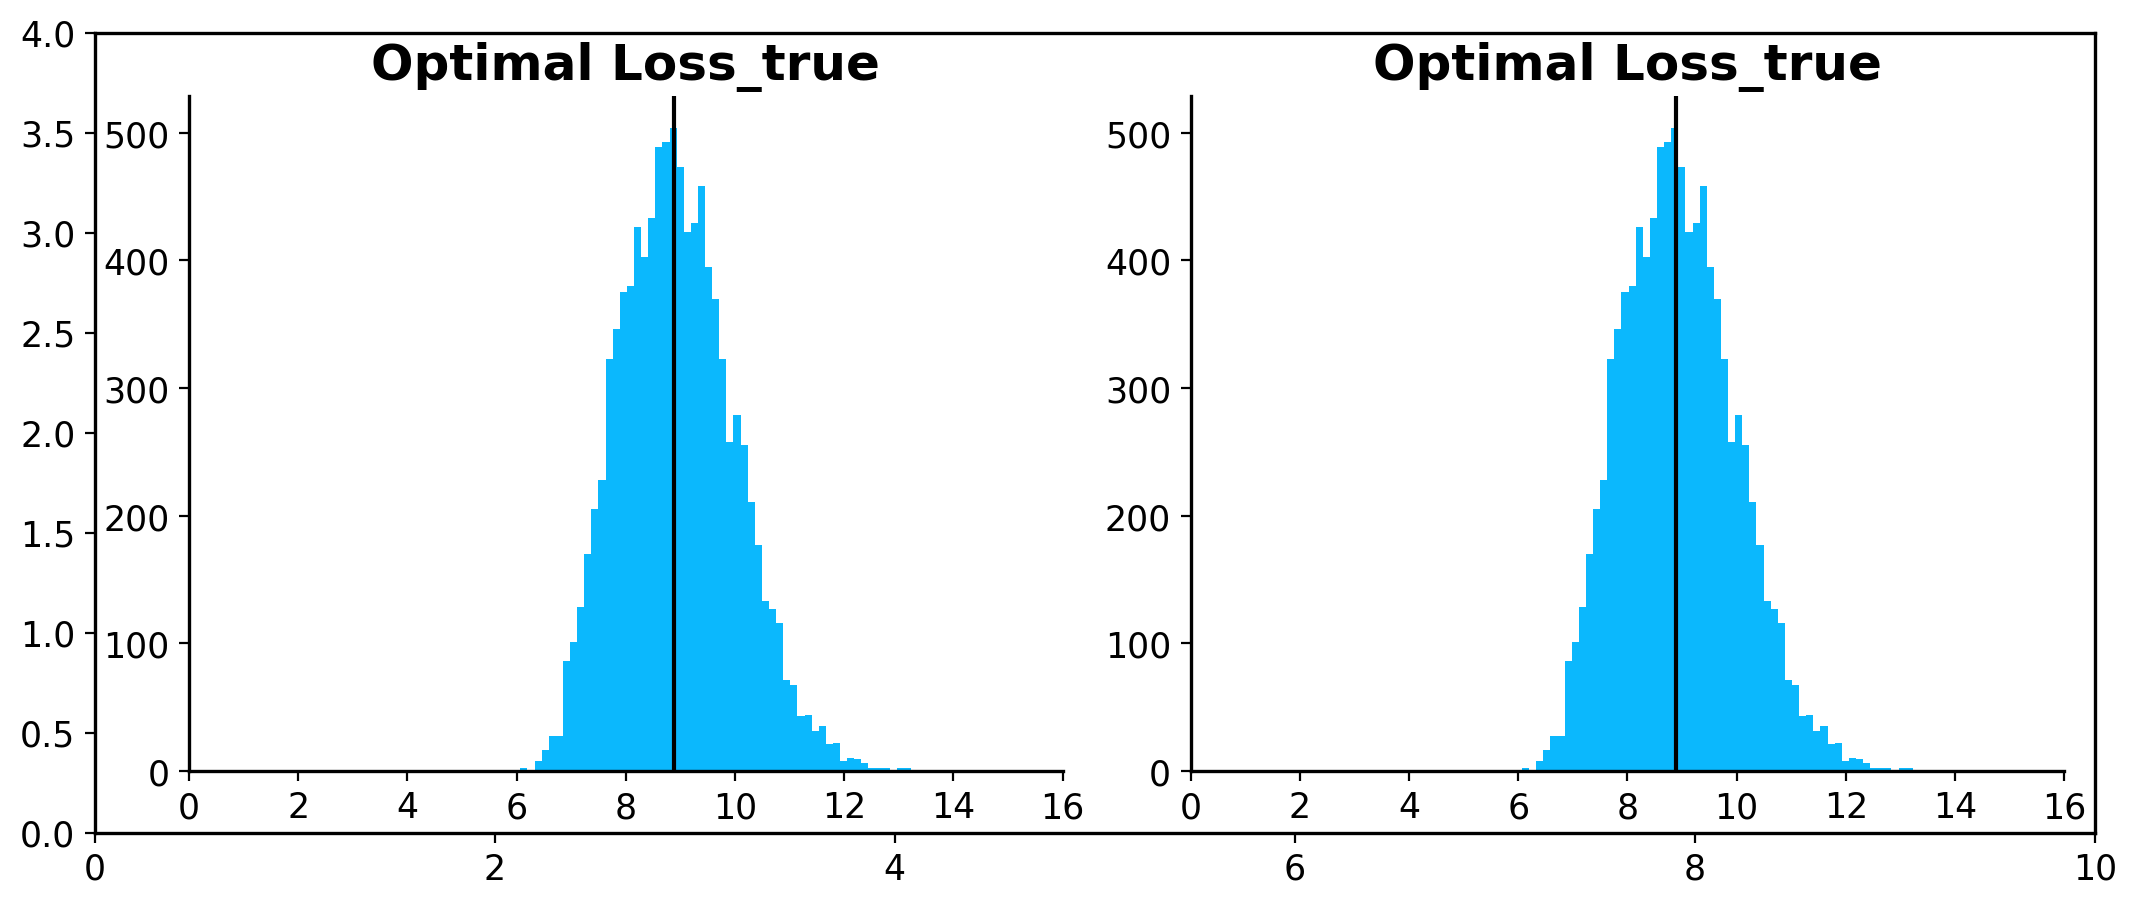

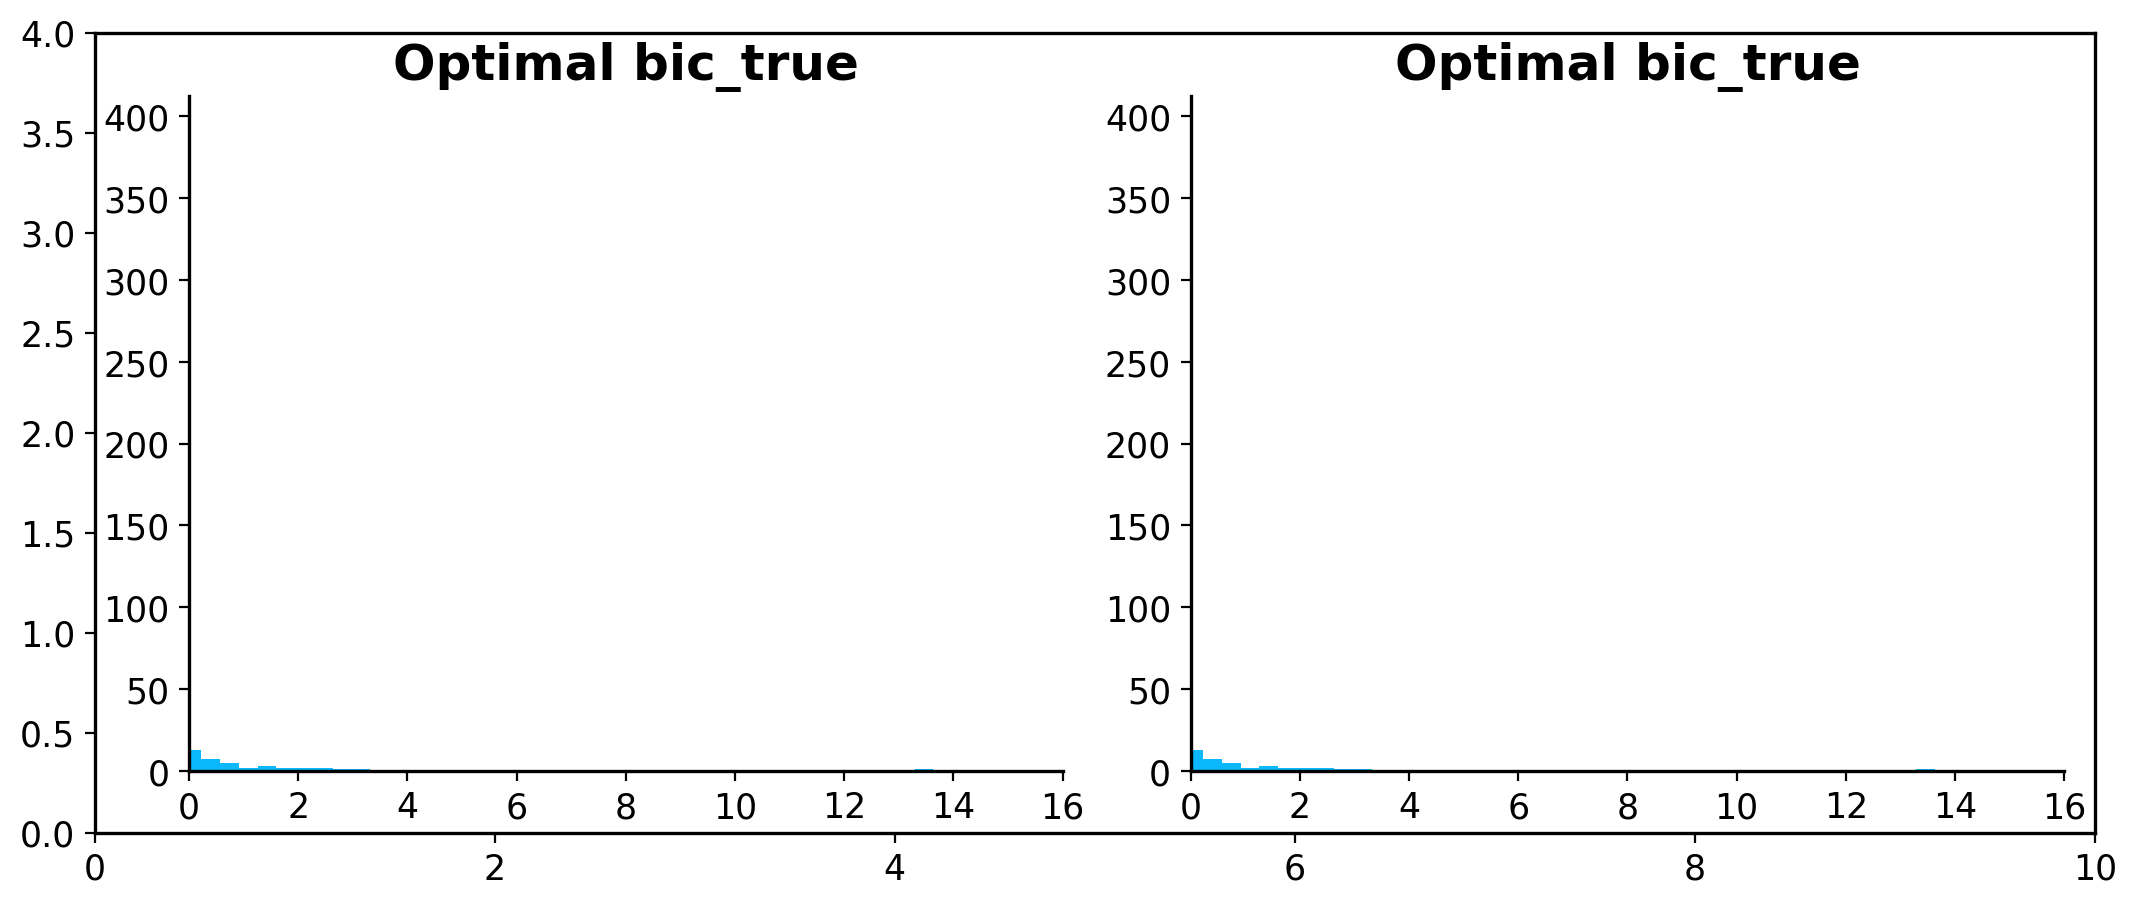

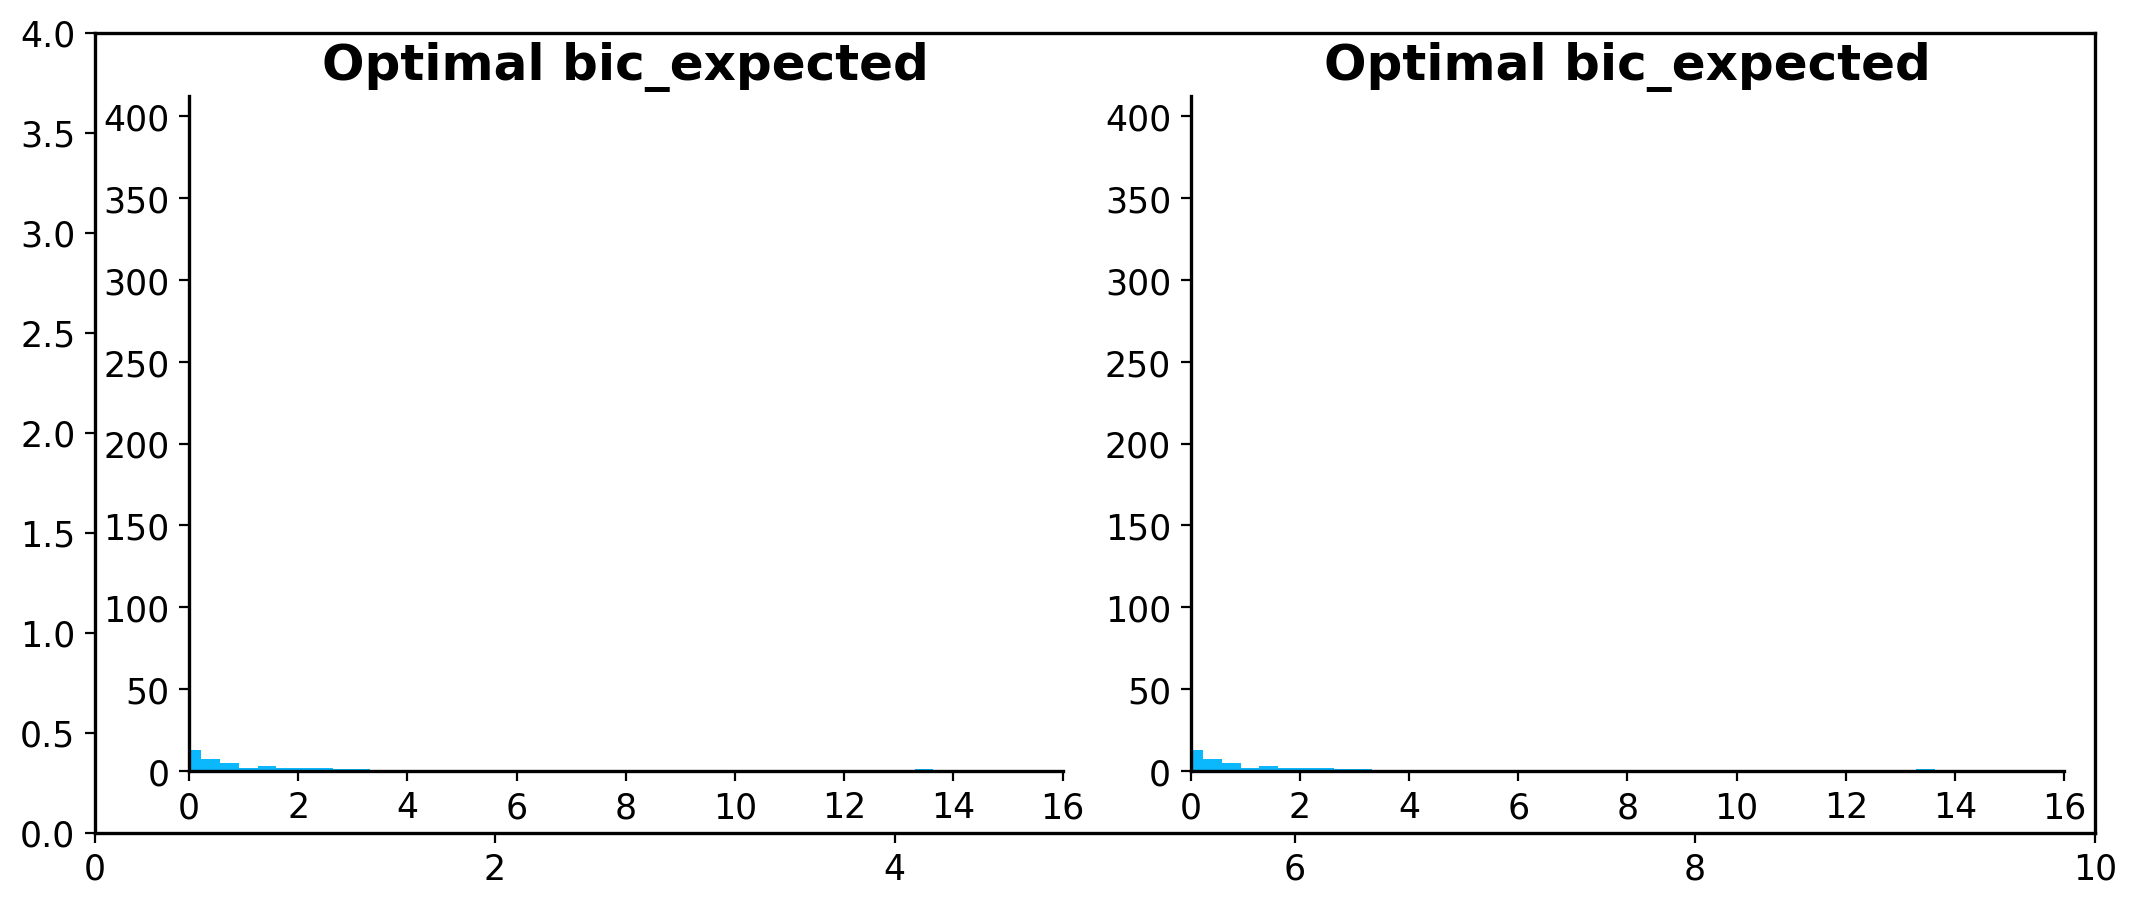

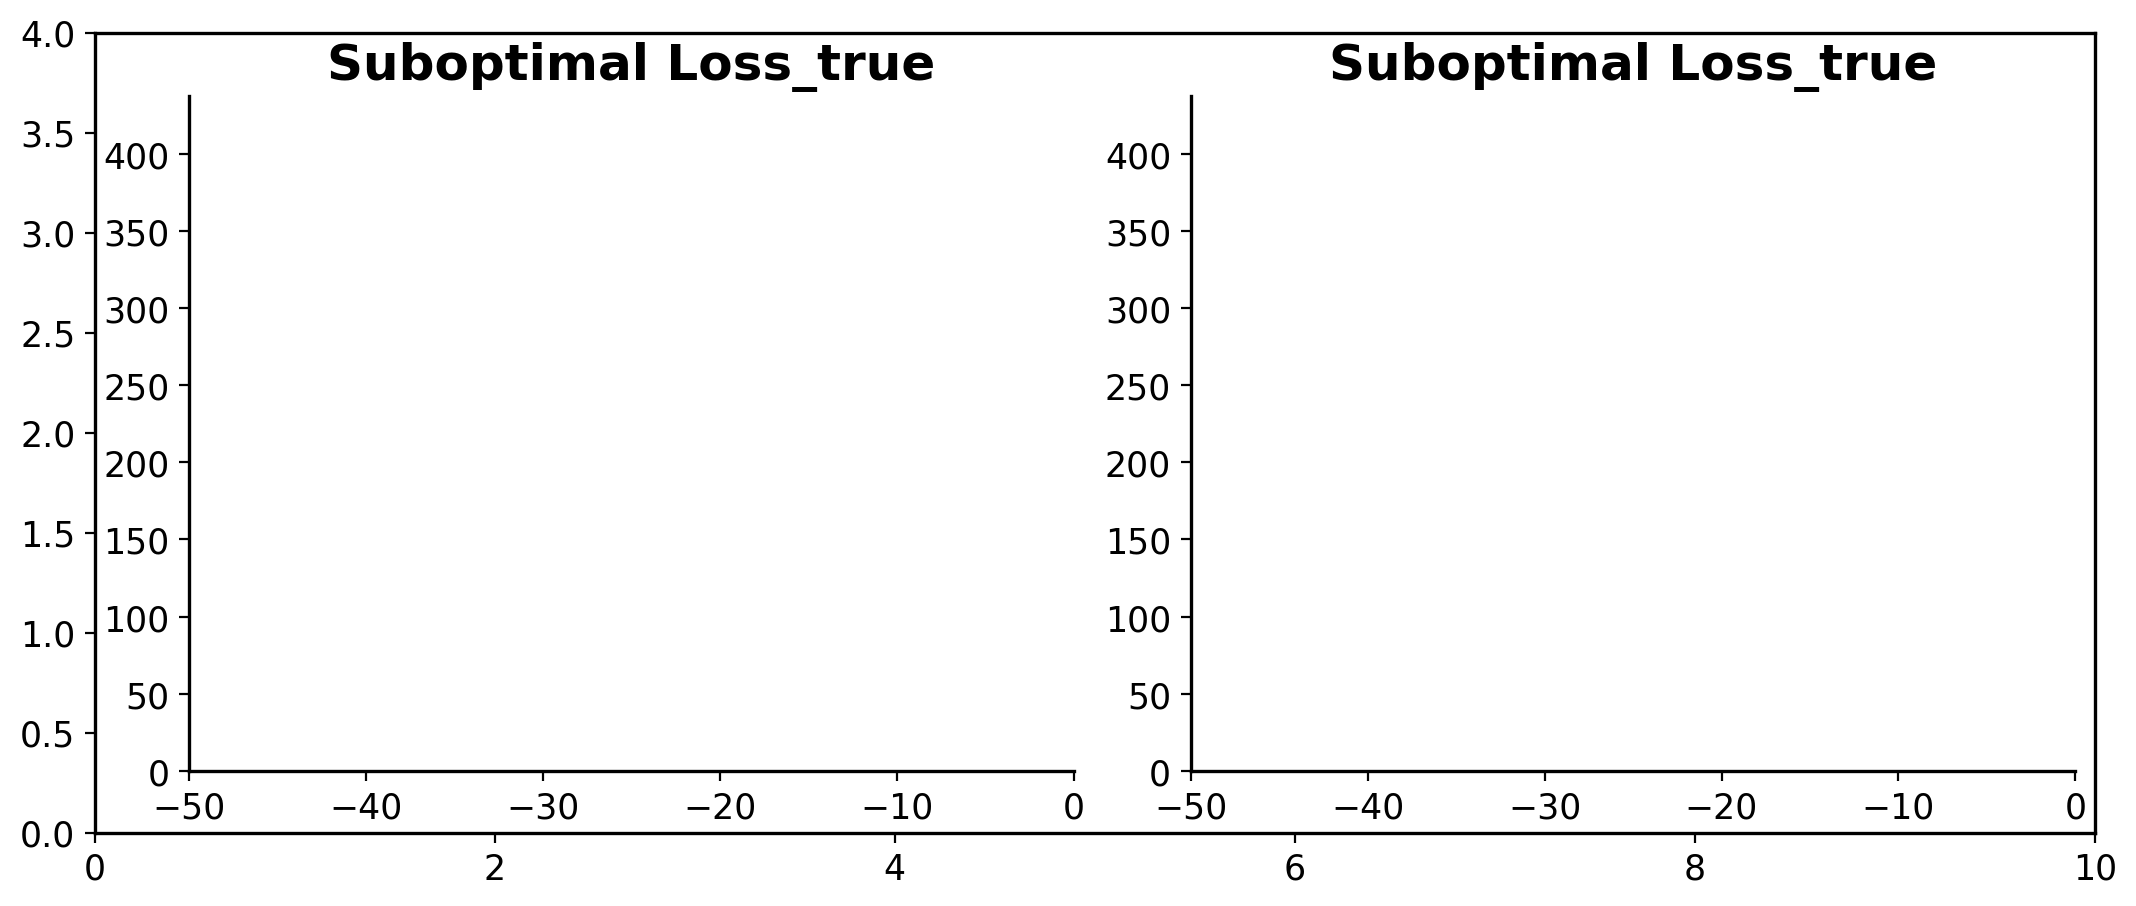

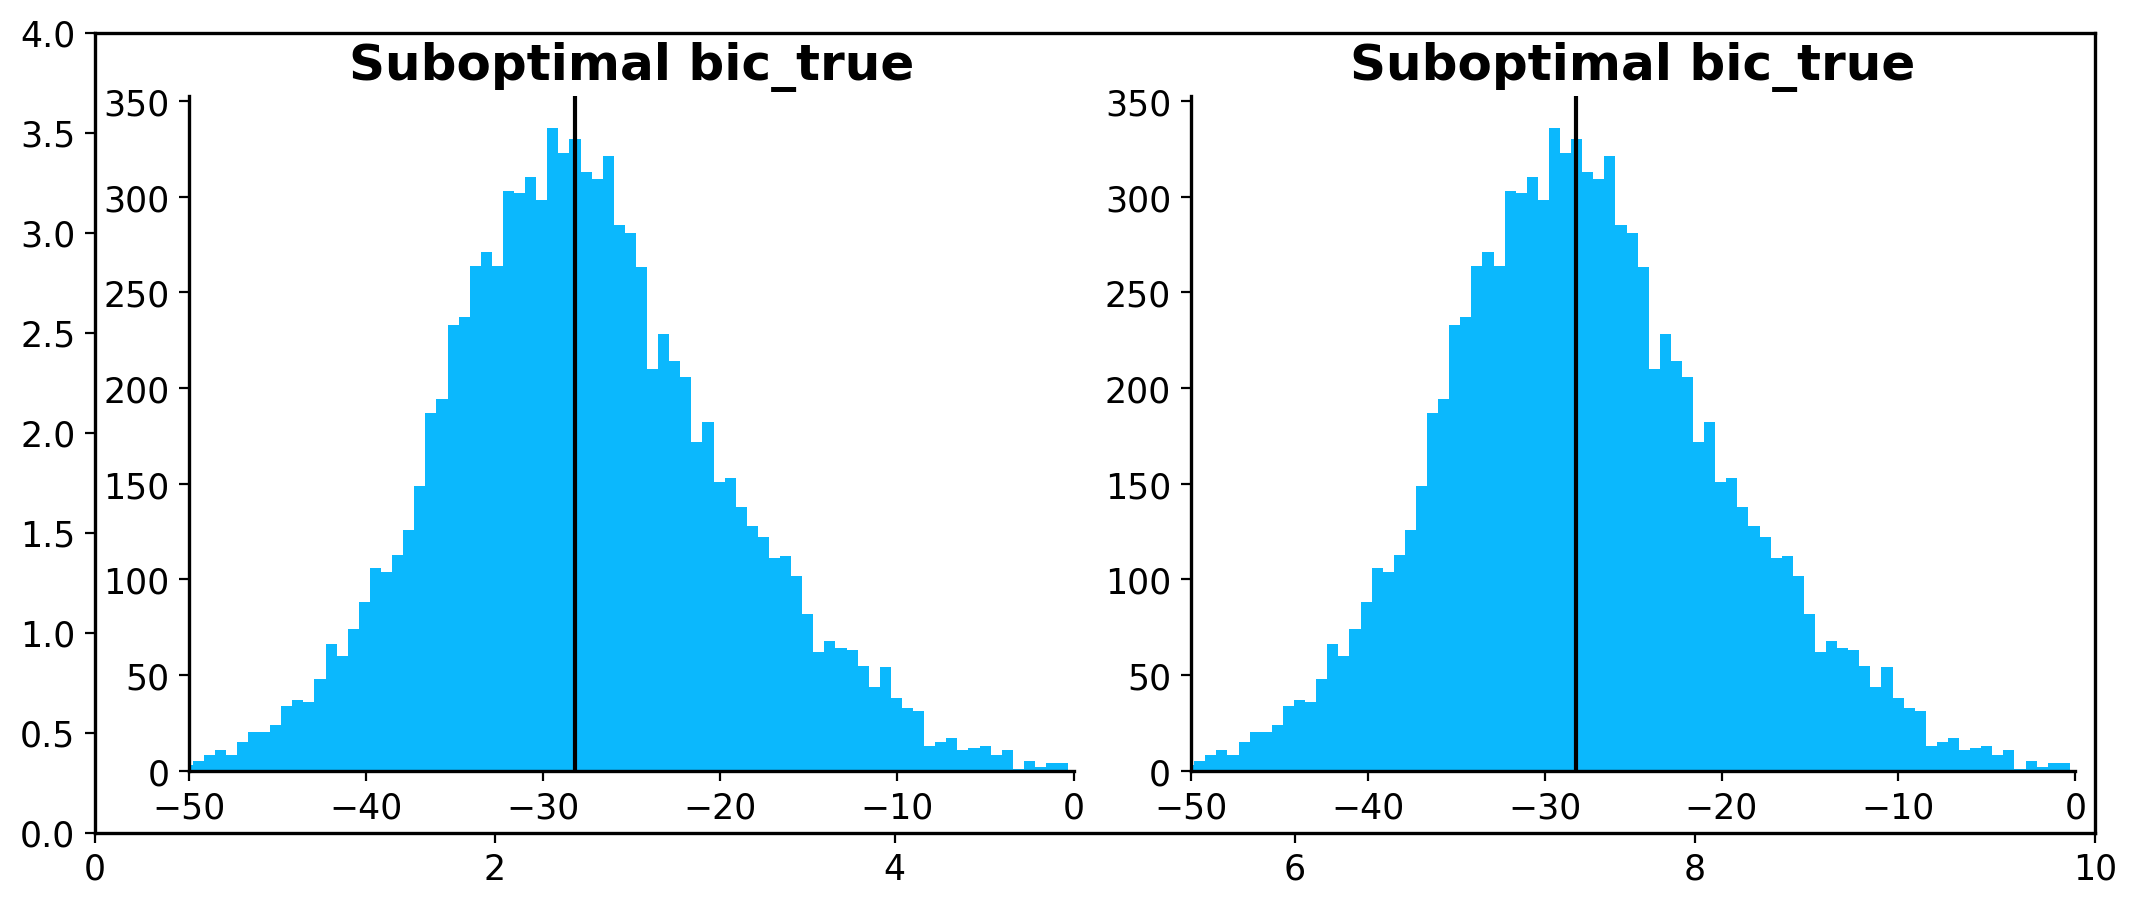

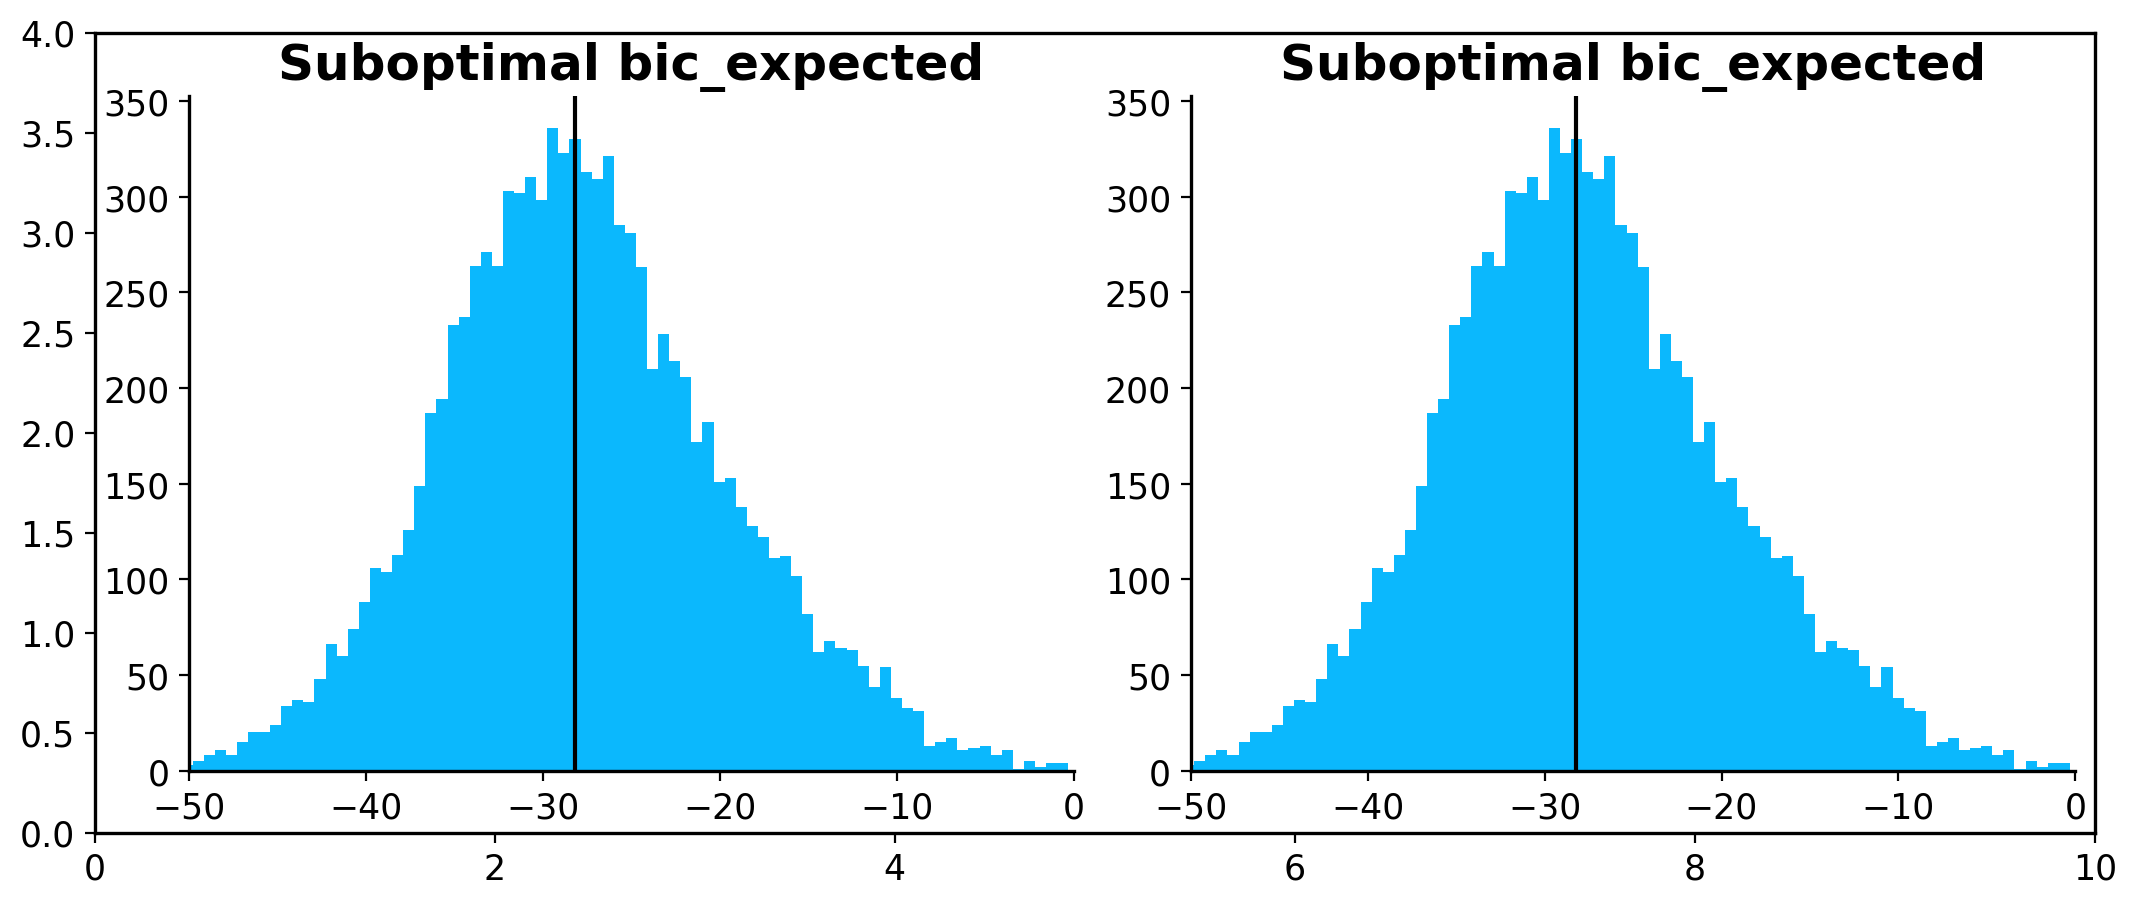

In [385]:
columns = ["Loss","bic",]
loss = [np.stack(model_results[0]["Loss"].to_numpy()).squeeze()]
loss.append(np.stack(model_results[1]["Loss"].to_numpy()).squeeze())
bic = [np.stack(model_results[0]["bic"].to_numpy()).squeeze()]
bic.append(np.stack(model_results[1]["bic"].to_numpy()).squeeze())

c= 0
for df_results,model_name in zip(model_results,model_names):
    for i,col_name in enumerate(columns):
        
        for j in range(2): # Looping through true and expected
            if col.ndim == 1:
                hist = col
                median = np.nanmedian(col)
                sd = np.nanstd(col)
                
            elif col.ndim == 2:
                hist = col[:,j]
                median = np.nanmedian(col[:,j])
                sd = np.nanstd(col[:,j])
            elif col.ndim == 3:
                hist = col[:,j,0]
                median = np.nanmedian(col[:,j,0])
            if j == 0:
                end_title = "_true"
            else:
                end_title = "_expected"
            
            fig = NewFigure("ab",figsize = (10,4),dpi=200)
            titles = []
            for k,ax in enumerate(fig.axes.values()):
                ax.hist(hist,align='mid',bins=100)
                ax.axvline(median)
                ax.set_title(model_name + " " + col_name + end_title)
                if k==0:
                    ax.set_xlim(0,16)
                else:
                    ax.set_xlim(-50,0)
                # fig.remove_figure_borders()
            plt.show()
            if col_name == "Loss":
                break
    c+=1
        

# Find Median and Confidence Intervals

In [307]:
np.median(np.stack(model_results[0]["median_movement_onset_time"].to_numpy()),axis=0)

array([1243.50003533, 1166.7787496 , 1180.50872037, 1152.8565565 ,
        431.82378508, 1082.04351841])

In [363]:
plot = False
col_names = ["median_movement_onset_time", "sd_movement_onset_time",
             "indecisions", "wins", "incorrects"]
optimal_medians = {}
optimal_intervals = {}

for i,col_name in enumerate(col_names):
    arr = np.stack(model_results[0][col_name].to_numpy())
    optimal_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    optimal_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]})    
    if plot:
        fig,axs = plt.subplots(2,3,dpi=150,figsize = (10,4))
        faxs = axs.flatten()
        for j in range(arr.shape[1]):
            ax = faxs[j]
            ax.hist(arr[:,j])
            ax.set_title(it.trial_block_titles[j], fontsize=8)
            if i>1:
                ax.set_xlim(0,100)
        fig.suptitle(col_name)
        plt.tight_layout()

suboptimal_medians = {}
suboptimal_intervals = {}
for i,col_name in enumerate(col_names):
    arr = np.stack(model_results[1][col_name].to_numpy())
    suboptimal_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    suboptimal_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]})     

In [364]:
from string import ascii_uppercase
import matplotlib.pyplot as plt
import matplotlib as mpl

class Figure:
    def __init__(self, axmain = None, ax = None, figsize = (6.5, 4), dpi = 150, invert = True):
        self.invert = invert
        self.figsize = figsize
        self.dpi = dpi
        self.letters = [] #letters for annotating figure
        self.panels  = [] #panels for figure
        
        if axmain == None and ax == None:
            self.figure = plt.figure(dpi = dpi, figsize = figsize, frameon=False)
            self.axmain = plt.gca()

            self.figure.patch.set_alpha(0)
            self.axmain.patch.set_alpha(0)
            self.axmain.set_position([0,0,1,1])

            self.axmain.set_ylim(0, figsize[1])
            self.axmain.set_xlim(0, figsize[0])
            
        #Enforces axes on regardless of stylesheet
        self.axmain.spines.top.set_visible(True)
        self.axmain.spines.right.set_visible(True)
        self.axmain.spines.bottom.set_visible(True)
        self.axmain.spines.left.set_visible(True)
        
        if invert:
            self.axmain.invert_yaxis()
        
    def remove_figure_borders(self):
        self.axmain.axis("off")
        
    def remove_panel_borders(self):
        for panel in self.panels:
            panel.axis("off")
        
    def add_letter(self, x, y, letter = None, fontsize = 12, ha = "left", va = "top", color = "black", zorder = 20):
        if letter == None:
            letter_to_add = ascii_uppercase[len(self.letters)]
        else:
            letter_to_add = letter
        
        self.letters.append(letter_to_add)
        self.axmain.text(x, y, letter_to_add, ha = ha, va = va, fontweight = "bold", color = color, fontsize = fontsize, zorder = zorder)
        
    def add_panel(self, dim):
        x = dim[0]/self.figsize[0]
        y = dim[1]/self.figsize[1]
        w = dim[2]/self.figsize[0]
        h = dim[3]/self.figsize[1]
        if self.invert:
            y = 1 - y
            
        panel = self.figure.add_axes((x,y,w,h))#, transform = self.axmain.transData)
        self.panels.append(panel)
        
        return panel
    
    def highlight_panel(self, panel):
        if isinstance(panel, int):
            for spine in self.panels[0].spines:
                self.panels[0].spines[spine].set_color("red")
                self.panels[0].spines[spine].set_visible(True)
                
        elif isinstance(panel, mpl.axes.Axes):
            panel.axis("on")
            for spine in panel.spines:
                panel.spines[spine].set_color("red")
                panel.spines[spine].set_visible(True)
                
    def savefig(self, path, dpi = 300, **kwargs):
        self.remove_figure_borders()
        self.figure.savefig(path, dpi = dpi, **kwargs)
    

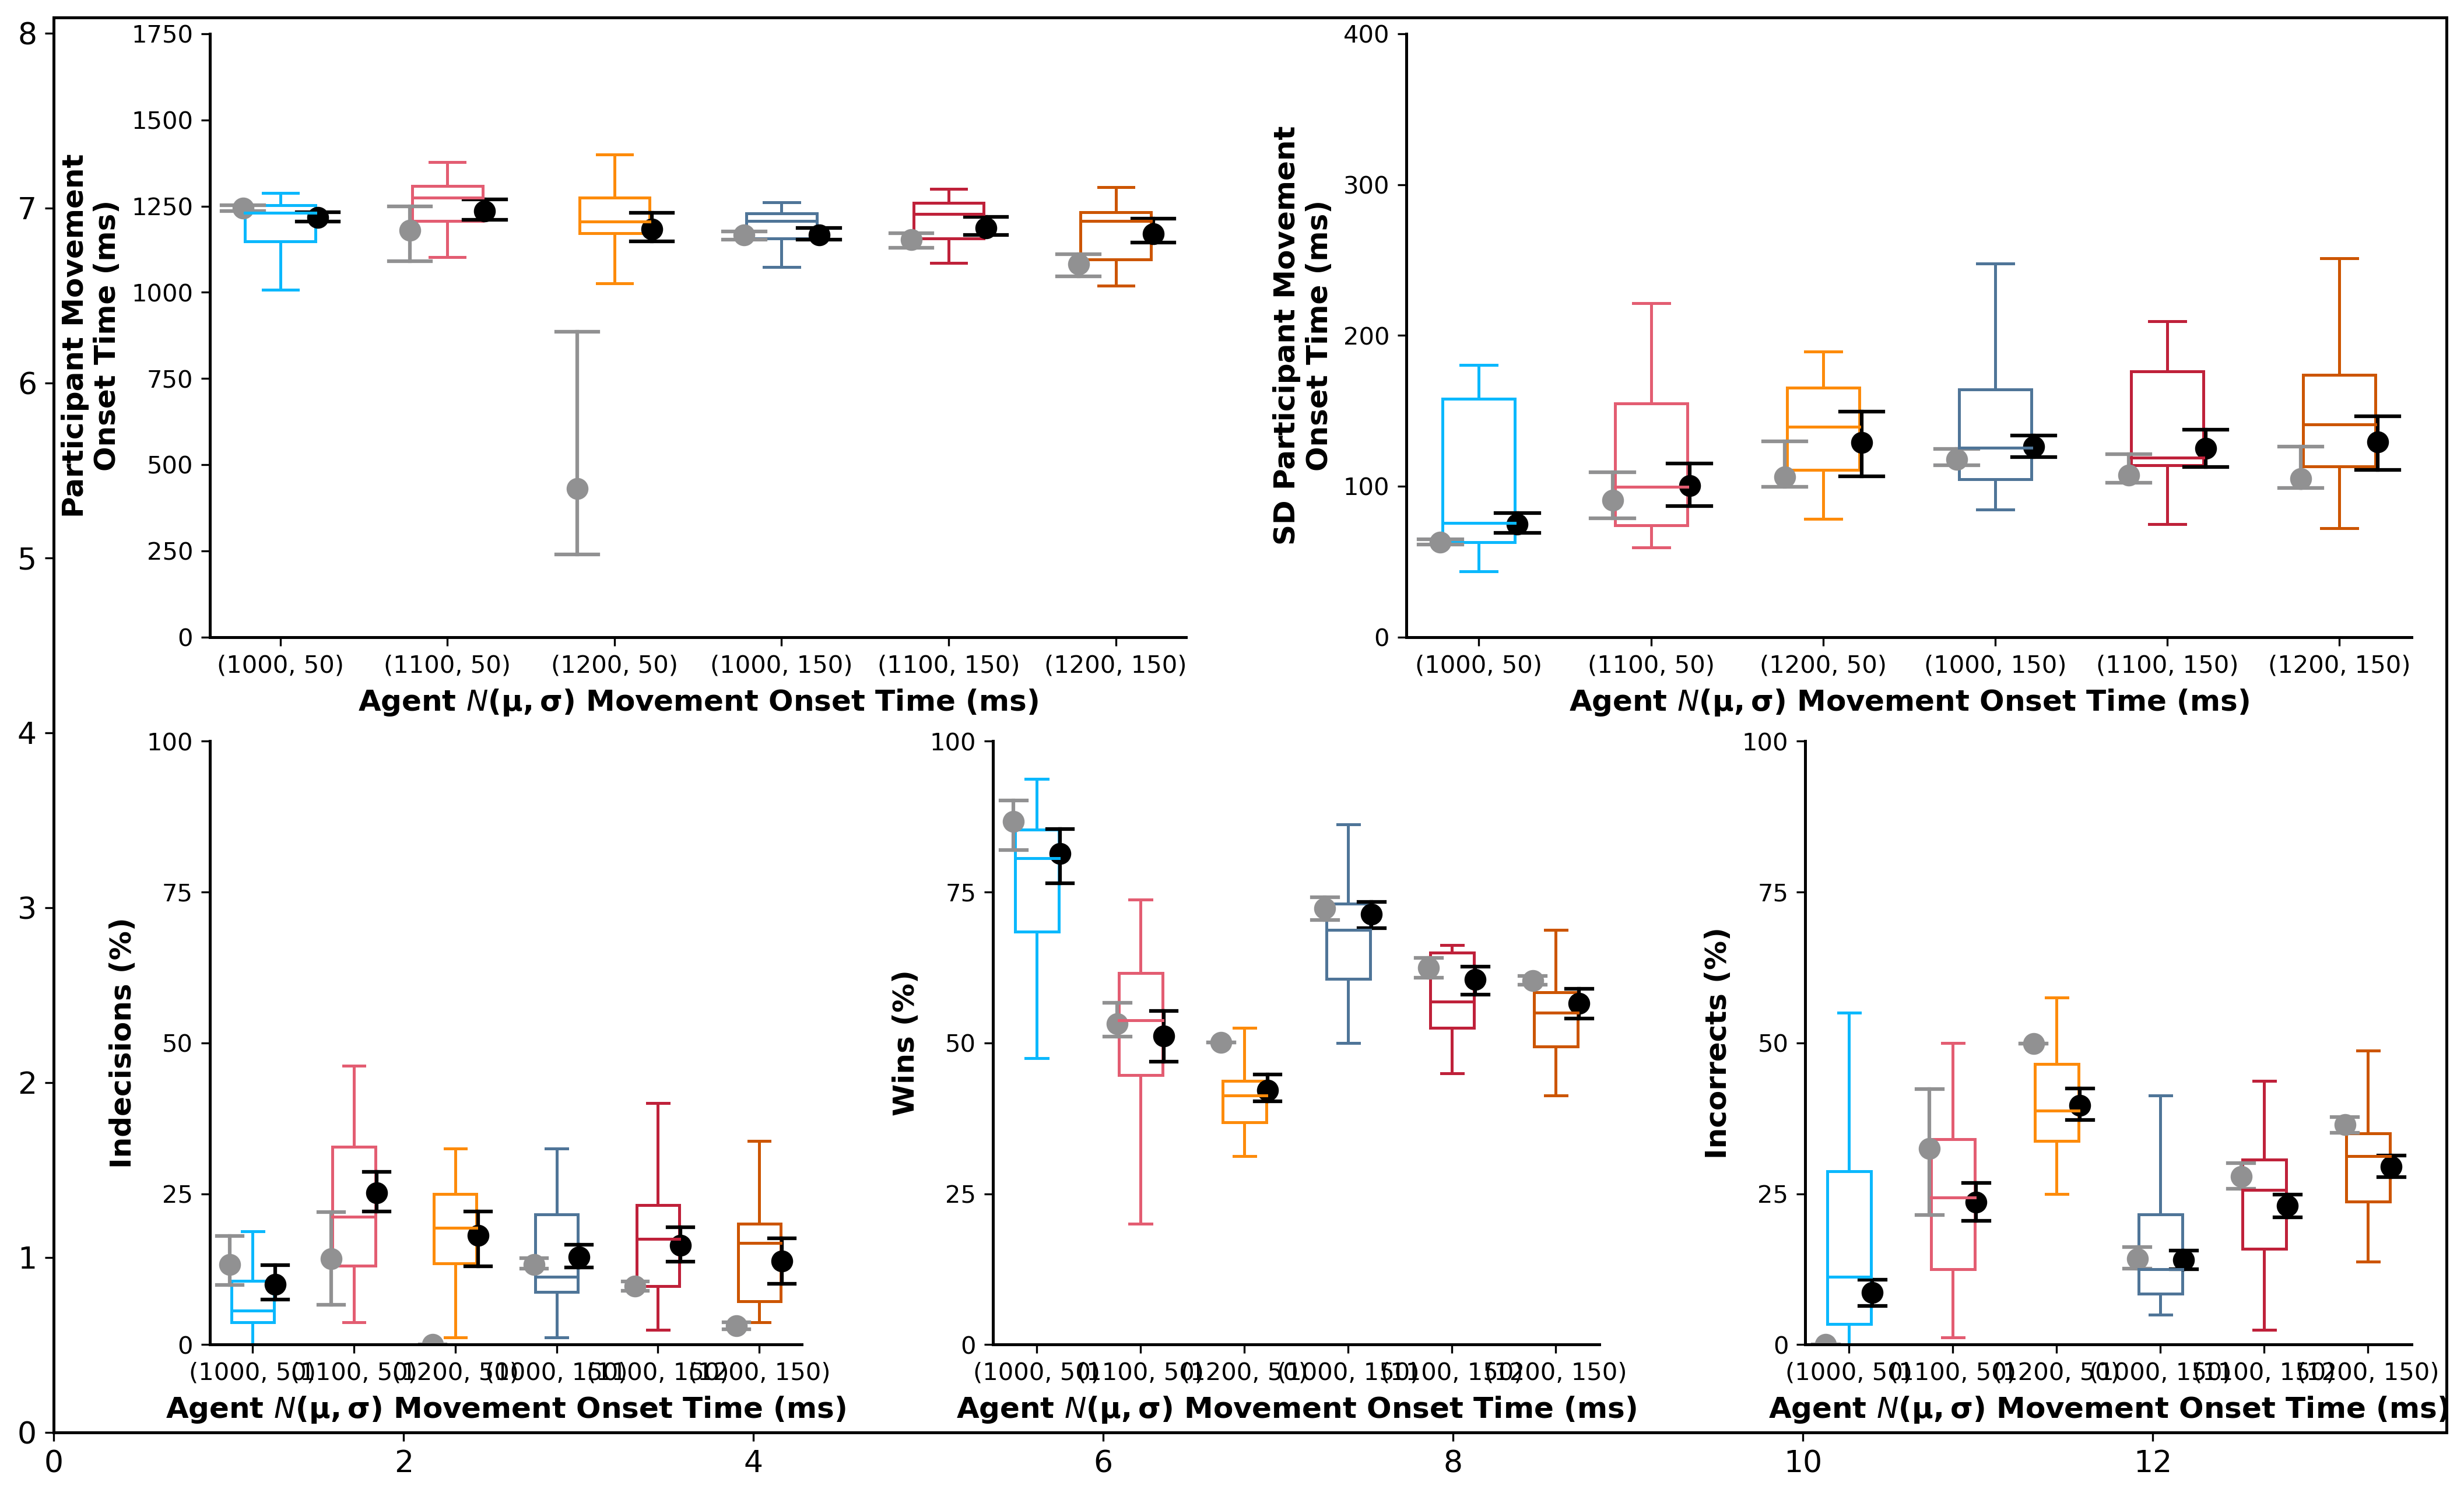

In [368]:
save_path = Path(r"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures")
w,h = 13.68,8.09
bw = (0.35*w)/it.num_blocks # box widths of all boxes combined takes up 30% of the width
mult_w, div_w = 0.053,2.3
div_h = 1.75
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
legend_fontsize = 10
ticklabel_fontsize = 10
suptitle_fontsize = 14
label_fontsize = 12

metrics = np.array([participant_median_movement_onset_time,
            participant_sd_movement_onset_time,
            participant_perc_indecisions,
            participant_perc_wins,
            participant_perc_incorrects,
            ]
)[:,:,[0,2,4,1,3,5]] # Rearranging axes to get the order I want 
ylocs = [np.arange(0, 1751, 250)] + [np.arange(0, 401, 100)] + [np.arange(0, 101, 25)]*3
ylabels = ['Participant Movement\nOnset Time (ms)','SD Participant Movement\nOnset Time (ms)', 
            'Indecisions (%)','Wins (%)','Incorrects (%)',]
ylims = [(0,1750)] + [(0,400)] + [(0,100)]*3

model_label = ['Optimal Model', 'Sub-Optimal Model']
# save_names = ["exp1_results_only_optimal_model", 'exp1_results_both_models','exp1_results_statistics',]
suptitles = ["Model Results", "Model Results", "Participant Behaviour"]
legend_locs  = (0.58,0.86)
median_dicts = [optimal_medians, suboptimal_medians]
interval_dicts = [optimal_intervals, suboptimal_intervals]

mosaic = "aaabbb;ccddee"
fig = NewFigure(mosaic, dpi=300, figsize = (w,h))
axs = list(fig.axes.values())
model_colors = [wheel.grey,wheel.black]
#* Looping axes for each metric
for i,(ax,col_name) in enumerate(zip(axs,col_names)):
    #* Looping each experimental condition
    for j in range(len(xlocs)):
        dv.boxplot(ax,xlocs[j],metrics[i,:,j],
                color = constants.xticklabel_colors_means[j],
                data_color=constants.xticklabel_colors_means[j],)
        for k,(model_medians,model_intervals) in enumerate(zip(median_dicts, interval_dicts)):
            if k == 0:
                shift = -bw/3
            if k == 1:
                shift = +bw/3 
            pf.plot_boostrapped_model_results(ax, xlocs[j]+shift, y = model_medians[col_name][j], 
                                              percentiles=model_intervals[col_name][:,j], 
                                              horizontal_lw=0.3, markersize=8, color = model_colors[k])
        
    # dv.jitter_array(ax=ax,x_positions=xlocs,data=metrics[i,:,:].T, 
    #                 data_color = constants.xticklabel_colors_means, 
    #                 data_edge_color = wheel.lighten_color(wheel.light_grey,1.2), 
    #                 noise_scale=0.06, include_mean = False, circle_size=40)

    ax.set_ylim(ylims[i])
    ax.set_xticks(xlocs, labels = constants.xticklabels, fontsize=ticklabel_fontsize)
    ax.set_yticks(ylocs[i],labels = ylocs[i], fontsize = ticklabel_fontsize)
    ax.set_xlabel(it.xlabel,fontsize=label_fontsize)    
    ax.set_ylabel(ylabels[i],fontsize=label_fontsize)    
        # [ticklabel.set_color(color) for (color,ticklabel) in zip(constants.xticklabel_colors_means,ax.xaxis.get_ticklabels())]
    
# fig.axes['a'].set_xlabel("xlabela")
# fig.add_all_letters() 
fig.fig.facecolor = 1
adjust_keys = ['c']
# for k in adjust_keys:
    # fig.adjust_position(fig.axes[k],(0,0))
    
bbox = fig.axes['c'].get_window_extent().transformed(fig.axmain.transAxes.inverted())

# fig.axes['c'].set_position((bbox.x0, bbox.y0,
#                             bbox.width, bbox.height))
# fig.pad_fig(w_pad=0.1,h_pad=0,w_space=-0.1,h_space=0.1)
# dv.legend()
plt.show()
fig.savefig(save_path / "test.png")

In [ ]:
fig.axmain.get_xlim()

(0.0, 13.68)

In [ ]:
bbox = fig.axes['c'].bbox.transformed(fig.axmain.transAxes.inverted())
bbox

Bbox([[0.06528614359974008, 0.06194245295975828], [0.3125939983121574, 0.48846271116604856]])

In [ ]:
bbox.x0/fig.figw

0.004772378918109655

In [ ]:
fig.axes['a'].yaxis.label.get_window_extent().transformed(fig.axes['a'].transAxes.inverted())

Bbox([[-0.15258864228803604, 0.19841754645154697], [-0.090700935093567, 0.8015824535484533]])

In [ ]:
fig.axes['a'].yaxis.label.get_window_extent().transformed(fig.fig.dpi_scale_trans.inverted())

Bbox([[0.04166999999999992, 5.23076388888889], [0.3870033333333334, 7.312013888888891]])

In [ ]:
fig = plt.figure(dpi = 150, figsize = (6,4), frameon=True,edgecolor="black")

# fig.set_xlim(0,20)
from matplotlib.transforms import Bbox, BboxTransformFrom, TransformedBbox
tr = BboxTransformFrom(Bbox.from_bounds(0, 0, *fig.get_size_inches()))
rect = TransformedBbox(Bbox.from_bounds(*rect_inches), tr).bounds
ax = fig.add_axes(rect)
ax.plot(np.arange())
plt.show()

NameError: name 'rect_inches' is not defined

<Figure size 900x600 with 0 Axes>

In [ ]:
fig.transFigure.transform((0, 0, *fig.get_size_inches()))

RuntimeError: In affine_transform: Invalid vertices array.